# A little Framework on Top of PyTorch
> for learning how Keras, Lightning & Fastai work
- toc: true
- branch: master
- badges: true
- image: images/narm.png
- comments: true
- author: Sajjad Ayoubi
- categories: [implementation]

## inspiration

- one month ago I was thinking about frameworks like Keras, Lightning & Fastai
  - these are on top of main frameworks like Tensorflow & PyTorch
- I found that the implementation is best for finding out `How`
- this was my inspiration
  - I looked to lighting and Keras 
  - and try to choose the best part from those
- the implementation is on `PyTorch`
- you can look at this and write your one little FrameWork
- I can't and don't want to create something like Keras from scratch
  - the main thing in these frameworks are **Training Loop** and **Callbacks**
  - we go through to implement these

- it was a little challenge for my weekend
  - I learned much from this project
  - and now I know that what Keras and Lightning does
  - the best thing that I learned was
    - the source code is the King !!!
  

## Impelementation

- first of all, we need to add some basic stuff

In [2]:
import time, sys, gc
from copy import deepcopy
import matplotlib.pylab as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

### Trainer
the most important thing is Training Loop

Model.fit in Keras, trainer in lighting
- I wanna create a Trainer class that gives some stuff like:
    - Model, training dataset, optimizer, and loss function
    - and does fit functionality like Sklearn and Keras

the `__init__` function is huge 

In [ ]:
class Trainer:

    def __init__(self, model, train_ds, valid_ds, optimizer, loss, 
                 train_bs=32, valid_bs=32, scheduler=None, scheduler_type='epoch', 
                 metrcis=[], workers=4, fp16=False, grad_clip_value='inf'):
        
        """
        Args:
          model: your model that you want to train (nn.Moudle)
          train_ds: any DataStructer that works with torch.Dataloder (DataSet, list, ...)
          optimizer: nn.optim
          loss: nn.losses or any function
          train_bs: training batch size (int)
          valid_bs: validation batch size (int)
          scheduler: torch.optim.lr_scheduler
          metrics: a list of function for custom matrix (list)
          scheduler_type: scheduler stratigy ('epoch', 'batch')
          grad_clip_value: value for gradient cilipping (int or 'inf')
          workers: num workers in dataloders (int)
          fp16: automatic mixed percision training (bool)
        
        Params:
          params: a dict for saving details like (loss, step number, epoch number, ...)
          stop_training: a bool for stopping training proccess 
        """
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scheduler_type = scheduler_type
        self.loss = loss
        self.metrcis = metrcis
        self.grad_clip_value = grad_clip_value
        self.fp16 = fp16
        self.scaler = GradScaler(enabled=fp16)
        self.workers = workers
        self.stop_training = False
        self.train_bs = train_bs
        self.valid_bs = valid_bs
        self.train_ds = train_ds
        self.valid_ds = valid_ds 
        self.train_dl = self.get_train_dataloder()
        self.params = {'train_steps': len(self.train_dl)}
        if valid_ds==None:
            self.valid_dl = None
        else:
            self.valid_dl = self.get_valid_dataloder()
            self.params['valid_steps'] = len(self.valid_dl)

- the first functionality of Trainer is to Create DataLoader from datasets

In [ ]:
    def get_train_dataloder(self):
        # create a DataLoder for train 
        return DataLoader(self.train_ds, batch_size=self.train_bs, shuffle=True, num_workers=self.workers)      
      
    def get_valid_dataloder(self): 
        # create a DataLoder for valid
        return DataLoader(self.valid_ds, batch_size=self.valid_bs, shuffle=False, num_workers=self.workers)

- the advantage of this implementation is you can override these functions
- see the following example

In [ ]:
class CustomTrainer(Trainer):
    def get_train_dataloder(self):
      # I override this and change the shuffle to False
      return DataLoader(self.train_ds, batch_size=self.train_bs, shuffle=False, num_workers=self.workers)   

- `fit` function

In [ ]:
    def fit(self, epochs=1, device='cuda', callbacks=[]):
        """
        it trains your nn for any epochs that you want
        
        Args:
            epochs: number of epochs for training (int)
            device: running device (torch.device)
            callbacks: list of callbacks that you want (list)
        """
        # set params
        if self.stop_training: return
        self.params['epochs'] = epochs
        self.change_device(device)
        self.state = CallbackRunner(callbacks, trainer=self)
        self.state.on_train_start
        # start train and valid epoch
        for epoch in range(1, epochs+1):
            self.params['epoch'] = epoch
            self.state.on_epoch_start
            # train
            self.state.on_train_epoch_start
            self.train_epoch() # train_for_one_epoch_on_train_dl
            self.state.on_train_epoch_end
            # schedule the learning rate
            if self.scheduler != None and self.scheduler_type == 'epoch':
                self.scheduler.step()
            # valid
            if self.valid_dl!=None:
                self.state.on_valid_epoch_start
                self.valid_epoch() # train_for_one_epoch_on_valid_dl
                self.state.on_valid_epoch_end    
              
            self.state.on_epoch_end
            if self.stop_training: 
                break
        self.state.on_train_end

- one of the utils is
    - `change_device` function for simply changing device at the start of training


In [ ]:
    def change_device(self, device='cuda'):
        """ change device of (model, loss, optimizer)
        Args:
            device: running device (torch.device)
        """
        # save device to self
        self.device = device
        self.model.to(device)
        self.loss.to(device)
        self.optimizer.load_state_dict(self.optimizer.state_dict())

- now we need a `train_epoch` function
  - train model with train dataloder for one epoch
  - we save all things with `self.prarms`
- Keras and Lightning also can train on TPUs and has distrubuted training
  - plus some other features
  
- now we need a train_epoch function
    - train model with train Dataloader for one epoch
    - we save all things with self.prarms
- Keras and Lightning also can train on TPUs and has distributed training
    - plus some other features

In [ ]:
    def train_epoch(self):
        """
        train the model for one epoch, it has:
          callbacks state changer
          device change for batch
          autocast for mixed percision
          backward 
          params saver
        """
        self.model.train()
        for step, batch in enumerate(self.train_dl, 0):
          self.params['step'] = step
          self.optimizer.zero_grad()
          # set device for this batch
          batch = [item.to(self.device) for item in batch]
          self.params['batch'] = batch
          self.state.on_train_batch_start

          if self.device == 'cuda': # GPU + FP16
              with autocast(enabled=self.fp16):
                  loss, metrics = self.train_step(batch) # train_for_one_batch
              # bawkward + gradient_cliping
              self.backward_step(loss)
              #  schedule_lr
              if self.scheduler != None and self.scheduler_type == 'batch':
                  self.scaler.step(self.scheduler)
              self.scaler.update()

          else: # like the above but on CPU
              loss, metrics = self.train_step(batch)
              self.backward_step(loss)
              if self.scheduler != None and self.scheduler_type == 'batch':
                  self.scheduler.step()

          # save stats
          self.params['loss'] = loss
          self.params['metrics'] = metrics
          self.state.on_train_batch_end
          if self.stop_training: 
              break

- `backward_step` is normally the same except for things like GANs

In [ ]:
    def backward_step(self, loss):
        if self.device == 'cuda':
            self.scaler.scale(loss).backward()
            clip_grad_norm_(self.model.parameters(), self.grad_clip_value)
            self.scaler.step(self.optimizer)
        else:
            loss.backward()
            clip_grad_norm_(self.model.parameters(), self.grad_clip_value)
            self.optimizer.step()       

- we have the same function for validation

In [ ]:
    def valid_epoch(self):
      """
      train model for one epoch on valid_ds, it has:
          callbacks state changer
          device change for batch
          autocast for mixed percision
          params saver
      """
        self.model.eval()
        with torch.no_grad():
            for step, batch in enumerate(self.valid_dl, 0):
              self.params['step'] = step
              batch = [item.to(self.device) for item in batch]
              self.params['batch'] = batch
              self.state.on_valid_batch_start

              if self.device == 'cuda': # GPU + FP16
                  with autocast(enabled=self.fp16):
                      self.params['loss'], self.params['metrics'] = self.valid_step(batch) # train_for_one_step
              else: # CPU
                self.params['loss'], self.params['metrics'] = self.valid_step(batch)
              
              self.state.on_valid_batch_end
              if self.stop_training: 
                break

- now we need normal `train_step` & `valid_step`
    - these function gave a batch of data and do one train step on it
    - Keras & Lightning have the same

In [ ]:
    def train_step(self, batch):
        """ train on one batch and compute metrics
        Args:
            batch: training batch (From Dataloder)
        Returns:
            loss: any loss that you compute
            metrics: come from compute_metrics function
        """
        x, y = batch
        out = self.model(x)
        loss = self.loss(out, y)
        metrcis = self.compute_metrics(out, y)
        return loss, metrcis

    def valid_step(self, batch):
        """ train on one batch of valid and compute metrics
        Args:
            batch: training batch (From Dataloder)
        Returns:
            loss: any loss that you compute
            metrics: come from compute_metrics function
        """
        x, y = batch
        out = self.model(x)
        loss = self.loss(out, y)
        metrcis = self.compute_metrics(out, y)
        return loss, metrcis

the main advantage is you can Override `train_step` & `valid_step`
  - and create your own `Trainer`
  - just like `Keras SubClassing` and `pl.LightningModule`
- see the following example

In [ ]:
class AutoEncoderTrainer(Trainer):
    def train_step(self, batch):
        x, _ = batch # we don't need y for AEs
        out = self.model(x)
        loss = self.loss(out, x) # compute reconstraction loss
        metrcis = self.compute_metrics(out, y)
        return loss, metrcis

- the second utils function is 
- `compute_metrics`:
  - for computing all metrics that you pass to Trainer
  - it saves those in a dict with name

In [ ]:
    def compute_metrics(self, pred, y):
      """ Compute metrics that you passed in __init__
      Args:
          pred: prediction of the model
          y: gronth truth
      Returns:
        res: a dict{metrics_name: result}
      """
      res = {}
      for f in self.metrcis:
        # use name of that functin for Logging
        res[f.__name__] = f(pred, y).item()
      return res

- now we have a really simple training that can work with these:
  - metrics 
  - callbacks
  - cpu, cuda
  - fp16, fp32
  - gradient cillping
  - ...

## CallBacks
- the second important thing in frameworks is Callbacks
- with the concept of callback, we can add anything that we want without
    - changing the training process
    - or any knowledge from Trainer
- I think the callbacks are really great
    - you can test new ideas (for example Adaptive Gradient Clipping)
    - just with creating a Custom Callback and adding it to fit


- we need a Basic callback class
  - we can override from this

In [ ]:
# Basic Class
class Callback():
    """ Base class for creating callbacks:
          with self in this class and its child
          you can access to all property from Trainer
    """
    def set_trainer(self, trainer):
        # get trainer object
        self.trainer = trainer

    def __getattr__(self, attr):
        return getattr(self.trainer, attr)

    # fit
    def on_train_start(self): pass
    def on_train_end(self): pass
    def on_epoch_start(self): pass
    def on_epoch_end(self): pass
    # train
    def on_train_epoch_start(self): pass
    def on_train_epoch_end(self): pass
    def on_train_batch_start(self): pass
    def on_train_batch_end(self): pass
    # valid
    def on_valid_epoch_start(self): pass
    def on_valid_epoch_end(self): pass
    def on_valid_batch_start(self): pass
    def on_valid_batch_end(self): pass
    def on_valid_step_start(self): pass
    def on_valid_step_end(self): pass

- we need a CallBack Handler
  - it gives a list of callbacks and runs all of them
  - in each state like `on_train_start`
  - and it has some `default_callbacks`

In [ ]:
class CallbackRunner():
    # callbacks runner (with default_callbacks)
    def __init__(self, callbacks, trainer):
        """
        Args:
          callbacks: list of callbacks (list)
          trainer: trainer object (Trainer)
        """
        # set StatsAvg, Reporter callbacks to default_callbacks
        default_callbacks = [StatsAvg(), Reporter(after_step=1)]
        self.callbacks = default_callbacks + callbacks
        for cb in self.callbacks:
          # set trainer object to all callbacks
          cb.set_trainer(trainer)

    # run all state with one function
    def __getattr__(self, attr):
        for cb in self.callbacks:
          getattr(cb, attr)()
        return None

- StatsAvg is the most important callbacks that we need
    - it keeps track of metrics and loss and computes the average of them

In [ ]:
class StatsAvg(Callback):
  # inner class for computing AVG with mommentom  
  class AvgRunner():
    def __init__(self, mom=None):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, step=1):
        self.val = val
        self.sum += val * step
        self.count += step
        self.avg = self.sum / self.count

  # helper functions
  def __init__(self, mom=None):
      self.mom = mom

  def update_all(self, items, step):
      for avg, item in zip(self.metrcis_runners, items):
          avg.update(item, step)

  def get_avgs(self, names):
      return {n:a.avg for a, n in zip(self.metrcis_runners, names)}
  

  # valid section
  def on_valid_epoch_start(self):
    self.metrcis_runners = [self.AvgRunner(self.mom) for i in range(len(self.metrcis))]
    self.loss_runner = self.AvgRunner(self.mom)

  def on_valid_batch_end(self):
    self.loss_runner.update(self.params['loss'].item(), self.valid_bs)
    self.params['loss'] = self.loss_runner.avg
    self.update_all(self.params['metrics'].values(), self.valid_bs)
    self.params['metrics'] = self.get_avgs(self.params['metrics'].keys()) 
        
  def on_valid_epoch_end(self):
    del self.metrcis_runners
    del self.loss_runner

  # train section
  def on_train_epoch_start(self):
    self.metrcis_runners = [self.AvgRunner(self.mom) for i in range(len(self.metrcis))]
    self.loss_runner = self.AvgRunner(self.mom)

  def on_train_batch_end(self):
    self.loss_runner.update(self.params['loss'].item(), self.train_bs)
    self.params['loss'] = self.loss_runner.avg
    self.update_all(self.params['metrics'].values(), self.train_bs)
    self.params['metrics'] = self.get_avgs(self.params['metrics'].keys())     

  def on_train_epoch_end(self):
    del self.metrcis_runners
    del self.loss_runner

- after having the AvgStats we need a Reporter
    - for printing stats like loss and metrics during training
- in creating callbacks order is really important

In [ ]:
class Reporter(Callback):
    def __init__(self, after_step=1):
        self.after_step = after_step

    def show(self, phase='train'):
        report = '   loss: ' + str(round(self.params['loss'], 4))
        report += '  ' + str('   ').join([f"{k}: {round(v, 3)}" for k, v in self.params['metrics'].items()])
        sys.stdout.write(f"\r {phase}_steps: {self.params['step']+1}/{self.params[f'{phase}_steps']}" + report)
        sys.stdout.flush()
    
    def on_valid_epoch_end(self): 
        print('', end='\n') 

    def on_valid_batch_end(self): 
        if self.params['step']%self.after_step==0:
            self.show('valid')

    def on_train_batch_end(self):
        if self.params['step']%self.after_step==0:
            self.show('train')

    def on_train_epoch_start(self): 
        print('\n Epoch %2d/%2d' % (self.params['epoch'], self.params['epochs']))
        print('-' * 75)
        self.t0 = time.time()

    def on_train_epoch_end(self):
        t1 = time.time() - self.t0
        print('  time: %.0fm %.0fs' % (t1//60, t1%60))

- so far we saw default callbacks but
  - we can create any callbacks that we want
- look at the following
  - a new callback for learning rate finding
  - it's a child of `Callback` Class

In [ ]:
class LRFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=5e-1, mom=0.9, update_steps=1):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom # Make loss smoother using momentum
        self.update_steps = update_steps # update lr after X batch
                
    def on_train_start(self):
        n_iter = self.params['train_steps']*self.params['epochs']    
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, num=n_iter//self.update_steps+1)
        self.losses = []
        self.best_loss = 0

    def on_train_batch_end(self):
        # in callbacks we have access to all params from Trainer
        loss = self.params['loss']
        step = self.params['step']
        if step!=0:
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        if step==0 or loss < self.best_loss: 
            self.best_loss = loss
        if step%self.update_steps==0:
            self.losses.append(loss)            
            # update lr
            lr = self.learning_rates[step//self.update_steps]            
            self.optimizer.param_groups[0]['lr'] = lr

        # Stop criteria
        if loss > self.best_loss*1.1:
            self.trainer.stop_training = True         
            
    def on_train_end(self): 
        print('\n')
        plt.figure(dpi=80)
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.title(f'I think we find it: {min(self.losses)/10}')
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

### Test: MNIST Classification
- now it's ready to use

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (255))])
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

- you can write any custom function for metrics

In [ ]:
# write your custom metrics
def acc(pred, y):
    pred = torch.argmax(pred, dim=1)
    return torch.mean((pred == y).float())

- we create model, loss, optimizer & scheduler

In [ ]:
def compile_model():
    model = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 10))
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.9)
    return model, loss, optimizer, scheduler

- now the create a Trainer object

In [ ]:
model, loss, optimizer, scheduler = compile_model()
learner = Trainer(model=model, train_ds=train_ds, optimizer=optimizer, loss=loss, metrcis=[acc])

- we need to create `lr_finder`
- and train it just for one epoch
  - you can see the acc right!!! 
  - and lr_finder works correctly


 Epoch  1/ 1
---------------------------------------------------------------------------
 train_steps: 389/469   loss: 2.255  acc: 54.095  time: 0m 10s




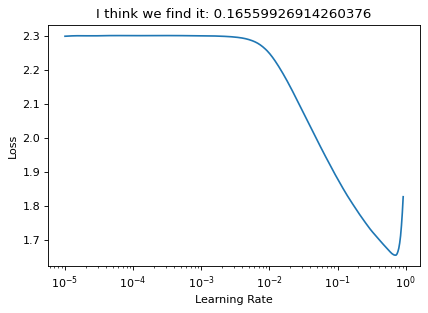

In [ ]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e1)
learner.fit(epochs=1, callbacks=[lr_finder], device='cpu')

In [ ]:
learner.fit(epochs=2, device='cpu')


 Epoch  1/ 2
---------------------------------------------------------------------------
 train_steps: 469/469   loss: 0.9052  acc: 0.741  time: 0m 13s

 Epoch  2/ 2
---------------------------------------------------------------------------
 train_steps: 469/469   loss: 0.3651  acc: 0.897  time: 0m 12s


- every thigs is right and now we can create any Trainer
  - imagine I want to add a new feature to my Trainer
  - the feature is something like `model.summary` in Keras

In [ ]:
from torchsummary import summary

class CustomTrainer(Trainer):
    def summary(self):
        summary(self.model.cpu(), input_size=(self.train_ds[0][0].shape), device='cpu')

In [ ]:
model, loss, optimizer, scheduler = compile_model()

learner = CustomTrainer(model=model, train_ds=train_ds, valid_ds=test_ds, optimizer=optimizer, loss=loss, metrcis=[acc])
learner.summary() # new feature

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              GELU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
learner.fit(epochs=3)


 Epoch  1/ 3
---------------------------------------------------------------------------
 train_steps: 469/469   loss: 0.9163  acc: 0.742  time: 0m 12s
 valid_steps: 157/157   loss: 0.4111  acc: 0.887

 Epoch  2/ 3
---------------------------------------------------------------------------
 train_steps: 469/469   loss: 0.3669  acc: 0.897  time: 0m 12s
 valid_steps: 157/157   loss: 0.3186  acc: 0.911

 Epoch  3/ 3
---------------------------------------------------------------------------
 train_steps: 469/469   loss: 0.3193  acc: 0.909  time: 0m 12s
 valid_steps: 157/157   loss: 0.2934  acc: 0.915


- for practice you can add these functions to your Trainer

In [ ]:
    def most_worse(self): pass
    def freeze(self): pass
    def unfreaze(self): pass
    def save(self): pass
    def load(self): pass
    def resume(self): pass
    def evaluate(self): pass
    def repuodicible(self): pass 

## All in one: Trainer Class

In [ ]:
class Trainer:
    def __init__(self, model, train_ds, valid_ds=None, train_bs=128, valid_bs=64, optimizer=None, loss=None, 
                 scheduler=None, scheduler_type='epoch', metrcis=[], workers=4, fp16=False, grad_clip_value='inf'):
        
        # without valid
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scheduler_type = scheduler_type
        self.loss = loss
        self.metrcis = metrcis
        self.grad_clip_value = grad_clip_value
        self.fp16 = fp16
        self.scaler = GradScaler(enabled=fp16)
        self.workers = workers
        self.stop_training = False # check
        # prepare dls
        self.train_bs = train_bs
        self.valid_bs = valid_bs
        self.train_ds = train_ds
        self.valid_ds = valid_ds 
        self.train_dl = self.get_train_dataloder()
        self.params = {'train_steps': len(self.train_dl)}
        if valid_ds==None:
            self.valid_dl = None
        else:
            self.valid_dl = self.get_valid_dataloder()
            self.params['valid_steps'] = len(self.valid_dl)
    

        
    # training 
    def fit(self, epochs=1, device='cuda', callbacks=[]):
        if self.stop_training: return
        self.params['epochs'] = epochs
        self.change_device(device)
        self.state = CallbackRunner(callbacks, trainer=self)
        self.state.on_train_start
        for epoch in range(1, epochs+1):
            self.params['epoch'] = epoch
            self.state.on_epoch_start
            # train
            self.state.on_train_epoch_start
            self.train_epoch()
            self.state.on_train_epoch_end
            if self.scheduler != None and self.scheduler_type == 'epoch':
                self.scheduler.step()
            # valid
            if self.valid_dl!=None:
                self.state.on_valid_epoch_start
                self.valid_epoch()
                self.state.on_valid_epoch_end    
              
            self.state.on_epoch_end
            if self.stop_training: 
                break
        self.state.on_train_end
        

        
    def train_epoch(self):
      self.model.train()
      for step, batch in enumerate(self.train_dl, 0):
          self.params['step'] = step
          self.optimizer.zero_grad()
          batch = [item.to(self.device) for item in batch]
          self.params['batch'] = batch
          self.state.on_train_batch_start
             
          if self.device == 'cuda': # GPU + FP16
              with autocast(enabled=self.fp16):
                  loss, metrics = self.train_step(batch)
              
              self.scaler.scale(loss).backward()
              clip_grad_norm_(self.model.parameters(), self.grad_clip_value)
              self.scaler.step(self.optimizer)
              if self.scheduler != None and self.scheduler_type == 'batch':
                  self.scaler.step(self.scheduler)
              self.scaler.update()

          else: # CPU
              loss, metrics = self.train_step(batch)
              loss.backward()
              clip_grad_norm_(self.model.parameters(), self.grad_clip_value)
              self.optimizer.step()
              if self.scheduler != None and self.scheduler_type == 'batch':
                  self.scheduler.step()

          # stats
          self.params['loss'] = loss
          self.params['metrics'] = metrics
          self.state.on_train_batch_end
          if self.stop_training: 
              break

    
    def valid_epoch(self):
        self.model.eval()
        with torch.no_grad():
            for step, batch in enumerate(self.valid_dl, 0):
              self.params['step'] = step
              batch = [item.to(self.device) for item in batch]
              self.params['batch'] = batch
              self.state.on_valid_batch_start

              if self.device == 'cuda': # GPU + FP16
                  with autocast(enabled=self.fp16):
                      self.params['loss'], self.params['metrics'] = self.valid_step(batch)
              else:
                self.params['loss'], self.params['metrics'] = self.valid_step(batch)
              
              self.state.on_valid_batch_end
              if self.stop_training: 
                break
        
        

    # -------------------------------------------------------------------------------- overrider
    def train_step(self, batch):
        x, y = batch
        out = self.model(x)
        loss = self.loss(out, y)
        metrcis = self.compute_metrics(out, y)
        return loss, metrcis

    def valid_step(self, batch):
        x, y = batch
        out = self.model(x)
        loss = self.loss(out, y)
        metrcis = self.compute_metrics(out, y)
        return loss, metrcis

    def get_train_dataloder(self): 
        return torch.utils.data.DataLoader(self.train_ds, batch_size=self.train_bs, shuffle=True, num_workers=self.workers)      
      
    def get_valid_dataloder(self): 
        return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.valid_bs, shuffle=False, num_workers=self.workers)


    # -------------------------------------------------------------------------------- utils
    def change_device(self, device='cuda'):
        self.model.to(device)
        self.loss.to(device)
        self.device = device
        self.optimizer.load_state_dict(self.optimizer.state_dict())


    def compute_metrics(self, pred, y):
        res = {}
        for f in self.metrcis:
            res[f.__name__] = f(pred, y).item()
        return res
    
    
    def summary(self):
        summary(self.model.cpu(), input_size=(self.train_ds[0][0].shape), device='cpu')


    def lr_finder(self, device='cuda', epochs=1, min_lr=1e-6, max_lr=1e1):
        init_weights = deepcopy(model.state_dict())
        # off valid epoch
        valid_dl = self.valid_dl
        self.valid_dl = None
        self.fit(epochs=epochs, device=device, callbacks=[LRFinder(min_lr=min_lr, max_lr=max_lr)])
        # reset training
        self.model.load_state_dict(init_weights)
        self.valid_dl = valid_dl
        self.stop_training = False


    def set_lr(self, lr):
        self.optimizer.param_groups[0]['lr'] = lr

- I hope you learned somthing and enjoed